Source publication for dataset: 
https://www.nature.com/articles/s41467-018-02866-0

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
from copy import deepcopy
import seaborn as sn

In [2]:
n_cells = 456
n_genes = 100
PWscores = np.zeros((n_cells, n_genes, n_genes))

for i in range(n_cells):
    path = "./../data/TEsmESC/geneXgene{i}.csv".format(i=(i+1))
    df_temp = pd.read_csv(path)
    PWscores[i, :, :] = np.copy(df_temp.values)
    

# Visualizing TE scores across cells (over time)

In [3]:
# heat_fig = sn.heatmap(PWscores[0, :, :], square=True)
    # as_file = heat_fig.get_figure()
    # path = "./../out/cell{i}.png".format(i = i + 1)
    # as_file.savefig(path)
    # ax.tick_params(left=False, bottom=False)

# The informative gene pathway extraction algorithm
(For now implemented as just an easy intuitive iterative solution, maybe later will attempt a numpy/C++ acceleration!)

In [4]:
# TODO: right now it is just greedy bfs, but I want paths to be able to branch and for multiple nodes to all connect to a common node
# eg. if you get 3-> 59, 18 -> 59 that outta be shown as 3&18 -> 59 (somehow)
"""
TODO: just build the incidence matrix as you go? each iteration adds a new set 'layer' of edges
--> see notes !
implement this proper (will write another function)
"""
def get_hyperedge_set(cell_index):

    cell_nw = PWscores[cell_index, :, :]
    
    # init
    paths = []
    max_itrs = n_genes
    itrs = 0
    tolerance = np.max(cell_nw) * 0.2 # all scores within whatever % of the max
    max_path_len = 0
    max_path_len_prev = -1

    for i in range(n_genes): #row is the predecessor node
        index_max = np.argmax(cell_nw[i, :]) # index of max column is the successor (incident) node
        
        if cell_nw[i, index_max] > tolerance:
            paths.append([i, index_max])

    # update
    while (max_itrs > itrs) and (max_path_len > max_path_len_prev):
        max_path_len_prev = max_path_len
        new_paths = deepcopy(paths) 
        for p in range(len(paths)):
            path = paths[p]
            if len(path) >= max_path_len:
                row = path[-1]
                index_max = np.argmax(cell_nw[row, :])
                
                if (cell_nw[row, index_max] > tolerance) and (index_max not in new_paths[p]):
                    new_paths[p].append(index_max)

        max_path_len = max( len(x) for x in new_paths )
        itrs += 1
        paths = deepcopy(new_paths)
    
    return paths

# Creation of the hypergraph

Note: a simple canonical edge has the form of tail->head

In [5]:
"""
Merges tails with common heads to identify all the multi-arity relations to represent as hedges and updates the supplied incidence matrix with these final hedges.
_edges: a list of tuples (tail_set, head_set) of all the initial single-tailed edges (note: they are sets, not lists!)
B: a list of n_gene-sized integer numpy arrays to represent the incidence matrix to update.
TODO: Test and be especially make sure Python's memory system isn't doing any weird reference copying and producing the wrong stuff!
Note, all set operations return copies, so this SHOULD be okay.
"""
def merge_edges(_edges, B):
    
    # init
    edges = deepcopy(_edges)
    m = len(edges)

    # Stop when there's only a single edge left (not possible to merge anything else)
    while (m >= 2):
        
        new_edges = [] 
        for i in range(0, m, 1):
            e1 = edges[i]
            for j in range(i + 1, m, 1):
                e2 = edges[j]
                common_heads = e1[1].intersection(e2[1])
                if (len(common_heads) > 0):
                    
                    # The new edge
                    new_tails = e1[0].union(e2[0]) 
                    new_edge = ([new_tails, common_heads])
                    new_edges.append(new_edge)

                    # Updating old edges (their head sets)
                    e1[1] = set(e1[1] - common_heads)
                    e2[1] = set(e2[1] - common_heads)

        
        # Add all edges with non-null head sets to the incidence matrix
        for edge in edges:
            col = np.zeros(n_genes)
            if len(edge[1]) > 0:
                for tail in edge[0]:
                    col[tail] = 1
                for head in edge[1]:
                    col[head] = 1

                B.append(np.copy(col))
        
        edges = deepcopy(new_edges)
        m = len(edges)

In [6]:
""" 
Creates a hypergraph, represented using an incidence matrix, from the given cell's PW gene network. 
cell_index: the index into the PWscores array for the desired cell.
p: percentage parameter to use in tolerance calculation; decides which relationships relative to the maximum PW TE. 
returns: B the incidence matrix of the constructed hypergraph. 
"""
def construct_hyper_graph(cell_index, p):
    # init
    unique_genes = set()
    cell_nw = PWscores[cell_index, :, :]

    # The incidence matrix (might use different data structure)
    B = []

    # all scores within whatever % of the max
    tolerance = np.max(cell_nw) * p

    tails = set(np.arange(start=0, stop=n_genes, step=1))

    # debug var
    count = 0

    # TODO: TEST IT ALL 
    while (len(tails) > 0):
        edges = []
        new_tails = set()
        heads_to_remember = set()

        for tail in tails:
            heads = set(np.flatnonzero(cell_nw[tail, :] > tolerance))
            
            # Termination condition: once there's no new heads added this never gets hit, no new tails get added and the tail set becomes null at the end of while itr
            if (len(heads) > 0) and (heads.isdisjoint(unique_genes)):
                
                count += 1
                
                for head in heads:
                    # error handling
                    if (cell_nw[tail, head] <= tolerance):
                        print("BIG BUG") # TODO: keep this error cond here and handle it better!

                    # update the next-level tails
                    new_tails.add(head)
                    
                    # TODO: maybe make the set of all heads for this level here and wait till the end of the iteration to deep copy it over?
                    heads_to_remember.add(head)
                    
                # update the edge set for this hgraph level
                tail_as_set = set()
                tail_as_set.add(tail)
                edges.append([tail_as_set, heads])
        
        # update the unique heads set
        # for e in edges:
        #     for h in e[1]:
        #         unique_genes.add(h)
        for h in heads_to_remember:
            unique_genes.add(h)

        merge_edges(edges, B)
        tails = set(deepcopy(new_tails))
    
    return B



In [7]:
hedges = []
for i in range(n_cells):
    G = construct_hyper_graph(i, 0.7)
    if (len(G) > 0):
        # networks.append(G)
        #TODO: ensure you keep two dims even if the input graph only has a single edge
        hedges.append(np.transpose(np.array(G)))
    # for e in G:
    #     # if (np.sum(e < 0)) >= 2:
    #         # print("This SHOULD happen, you know from the pathway function, so either this is a bug OR the uniqueness invariant is too strong!\n")
    #     if (np.sum(e < 0) == 0):
    #         print("bug")
    #     if (np.sum(e > 0) == 0):
    #         print("a lesser bug")
    #     if (np.sum(e < 0) > 1) and (np.sum(e > 0) > 1):
    #         print("Number of tails: {x}".format(x=np.sum(e < 0)))
    #         print("Number of heads: {x}\n".format(x=np.sum(e > 0)))

# TODO: Test proper via some contrived examples
# len(networks[0][0]) list of lists of numpy arrays
# for g in networks:
# n1 = np.array(np.transpose(networks[0]))
# n2 = np.array(np.transpose(networks[1]))
# n3 = np.array(np.transpose(networks[2]))
# res = []
# # res.append(n1)
# np.concatenate([n1, n], axis=1).shape
# np.transpose(networks[0]).shape

In [8]:
H = np.concatenate(hedges, axis=1)
H.shape

(100, 2065)

# Merging the edges into one big hypergraph for clustering

In [9]:
from sklearn.cluster import KMeans

L = H @ np.transpose(H)
eigvals, eigvecs = np.linalg.eig(L)

# sort based on eigenvalues
vecs = eigvecs[:,np.argsort(eigvals)]
vals = eigvals[np.argsort(eigvals)]


# TODO: Finding the number of clusters correctly?
# k = vals.shape[0] - np.sum(vals  0)
k = 10
# TODO: Fit from the first non-zero eigenvalue? Need to do this?
index = np.where(vals > 0)[0][0] 

kmeans = KMeans(n_clusters=k)
kmeans.fit(vecs[:,])
np.unique(kmeans.labels_, return_counts=True) # clusters and the number of genes assigned to each cluster


/home/dennis/miniconda3/envs/bioinformatics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 1,  1,  1,  2, 73,  3, 15,  2,  1,  1]))

In [10]:
gene_labels = df_temp.columns.to_numpy()
# gene_labels[0] == 'SOX2'
num_clusters = np.unique(kmeans.labels_).shape[0] #want a set for each cluster

clusters = []
for i in range(0, num_clusters, 1):
    genes = np.argwhere(kmeans.labels_ == i).flatten()
    if genes.shape[0] > 1:
        clusters.append(genes)

for c in clusters:
    if len(c) > 10 and len(c) < 20:
        # print("here")
        print(gene_labels[c])

['EPAS1' 'ZFP42' 'TCF15' 'ETV5' 'CREB3L2' 'NFXL1' 'SOX7' 'SNAI1' 'CREB3'
 'ZFP57' 'ZFP710' 'HOPX' 'KLF3' 'ELF2' 'TFEB']


Text(0, 0.5, 'counts')

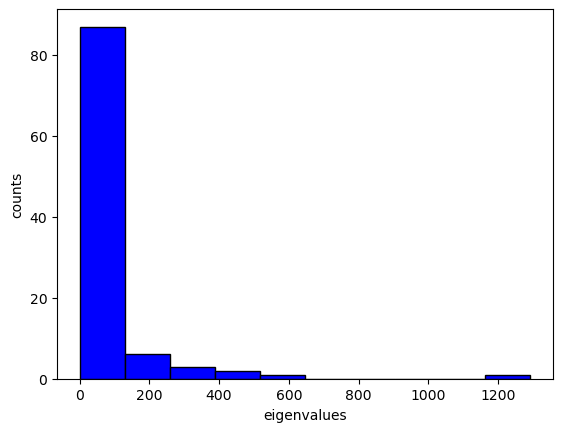

In [11]:
# # sn.histplot(eigs)
import matplotlib.pyplot as plt
# #456 vectors, each one has a set of values, I want a count for each unique value
eigvals[eigvals < 1] = 0
# eigvals = np.argwhere(eigvals > 10)
bins, counts = np.unique(eigvals, return_counts=True) # tuple for each eigen value: the value and its count
# # sn.histplot(x=hist[1], y=hist[0])
# # plt.pyplot.hist(bins, weights=counts)
plt.hist(bins[:], color = 'blue', edgecolor = 'black', weights=counts[:])
plt.xlabel("eigenvalues")
plt.ylabel("counts")